In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stripROtools
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import crystalball

from stripROtools import colors
from stripROtools import GetTransErrs
from stripROtools import gaus2
from stripROtools import Mismeasurment_vs_z
from stripROtools import random_three_vector
from stripROtools import plot_track

In [2]:
# Solid angle range in theta [degrees]
theta_min = 15
theta_max = 30

# Drift length in cm
DL = 10.0

# Transverse diffusion in cm/sqrt(cm)
DTrans = 0.0135


# Instead of Po210 tracking we simulated charges spreadout along a line with 500 charges per 0.1 cm

In [3]:
# The paramters, in order, are:
# number of simulations
# minimum angle to vertical [degrees] - this is based  on requiring a min. of 5 hits
# maximum angle to vertical [degrees]
# drfit length [cm]
# Apply diffusion T/F
# Transverse diffusion coefficent from Magboltz [cm/sqrt(cm)]
# W-value as obtained using degrad

def sim_p210(n_sims = 500, theta_min = theta_min, theta_max = theta_max, DL = DL, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2):

    tracks = pd.DataFrame(columns = ['direction', 'start', 'track'])

    for i in range(n_sims):

        # draw a random direction within specified solid angle (pointing down towards the readout plane)
        v = random_three_vector(theta_min,theta_max)

        # Maximumm track length of alpha track
        L_max = -DL/v[2]

        # Length segments we will distribute charge on, 0.1 is the resolution of length of the SRIM simulation
        L_segments = np.arange(0,L_max+0.1,0.1)


        #find left and right edges for each bin
        Left_edges = L_segments[0:-1]
        Right_edges = L_segments[1:]

        track = np.empty((0,3))

        # 1000 electrons per segment
        for left_edge,right_edge in zip(Left_edges,Right_edges):

            Ts = np.random.uniform(low=left_edge,high=right_edge,size=500)

            if Diff == False:

                x_vals = Ts*v[0]
                y_vals = Ts*v[1]
                z_vals = DL + Ts*v[2]

                Track_segment = np.array([x_vals,y_vals,z_vals]).T

                track = np.append(track,Track_segment,axis=0)
            
            elif Diff == True:

                z_vals = DL + Ts*v[2]

                x_vals = Ts*v[0] + DTrans*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))
                y_vals = Ts*v[1] + DTrans*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))
                z_vals = z_vals + DLong*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))

                Track_segment = np.array([x_vals,y_vals,z_vals]).T

                track = np.append(track,Track_segment,axis=0)

        x_rand = np.random.uniform()-0.5
        y_rand = np.random.uniform()-0.5

        track[:,0] = track[:,0]+x_rand # randomize x position (1 cm random uniform dist)
        track[:,1] = track[:,1]+y_rand # randomize x position (1 cm random uniform dist)

        tracks = tracks.append({'direction' : v, 'start' : np.array([x_rand,y_rand,DL]), 'track' : track }, ignore_index = True)

    return tracks




In [4]:
# Example of track simulation
tracks = sim_p210(n_sims = 100)
tracks.head()

,direction,start,track
0,"[-0.1664537872876477, -0.2317711991956443, -0....","[0.02308459397356688, -0.041766772670819186, 1...","[[-0.040342807321676444, -0.0964812640489067, ..."
1,"[-0.21808567133745058, 0.3416939489920578, -0....","[0.08913024310887474, -0.055654558668065346, 1...","[[0.016215831881103066, -0.0892550201425214, 9..."
2,"[0.36173919134379023, -0.06597171729618725, -0...","[-0.14081173084418297, 0.40688145869265946, 10.0]","[[-0.10207899966454721, 0.3312659307556144, 9...."
3,"[0.38632492386014256, 0.013328285188271477, -0...","[0.46040939729991925, -0.21672773807531065, 10.0]","[[0.5009802925801237, -0.25005352131550795, 9...."
4,"[0.2409349653327686, 0.20884697232750699, -0.9...","[-0.38129302370861284, 0.1199923239299957, 10.0]","[[-0.34172832147812654, 0.1147721600874665, 9...."


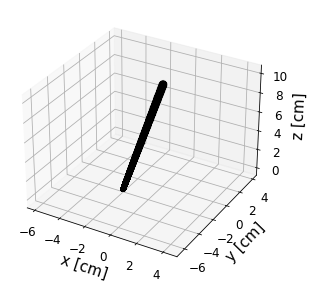

In [5]:
# Plot a Track
index = 0
track = tracks.iloc[index]["track"]
plot_track(track)

## Check point res versus z of raw simulations

In [6]:

all_z = np.array([])
all_x_err_1 = np.array([])
all_y_err_1 = np.array([])
all_x_err_2 = np.array([])
all_y_err_2 = np.array([])

for index, row in tracks.iterrows():

    track = row.track.T

    z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( track[0], track[1], track[2], np.ones(len(track[0])), charge_weighting = True)

    ang_z = np.arccos(v_PA[2])*57.2958


    if (ang_z>theta_min) and (ang_z<theta_max):
            
        all_z = np.append(all_z,z_vals)
        all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
        all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
        all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
        all_y_err_2 = np.append(all_y_err_2,delta_ys_2)


# change to um
all_x_err_2 = all_x_err_2 / 1E-4
all_y_err_2 = all_y_err_2 / 1E-4

sigma x:  44.00521767652995 +/- 0.10795651838414004
sigma y:  43.84258280785059 +/- 0.10726332278951475
sigma x:  77.95741781578666 +/- 0.17243553028993722
sigma y:  77.62226413495868 +/- 0.17148358835190536
sigma x:  100.32551167595389 +/- 0.232264181549688
sigma y:  99.50898958583255 +/- 0.2310905963447262
sigma x:  118.02435883709296 +/- 0.3034375301816505
sigma y:  117.40780586635603 +/- 0.30273297163086954
sigma x:  -133.77509186639557 +/- 0.39514579245355386
sigma y:  -132.90324985396848 +/- 0.38914931178185425
sigma x:  148.3087128147664 +/- 0.4997029199121857
sigma y:  147.31712431022706 +/- 0.49245072631587067
sigma x:  159.89676626097793 +/- 0.6065806608089243
sigma y:  -159.87480770625092 +/- 0.6046269206625854
sigma x:  -173.59975383480247 +/- 0.7499105631366934
sigma y:  170.96697349016102 +/- 0.7223531589190737
sigma x:  -183.6560669271834 +/- 0.8757252037393009
sigma y:  180.4426734607518 +/- 0.839571754311138
sigma x:  195.01591708587597 +/- 1.0370740512009091
sigma y: 

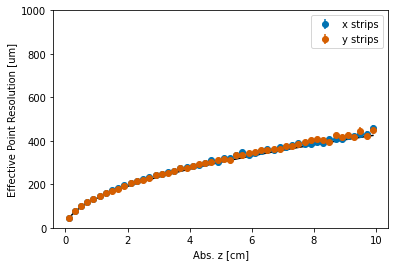

In [7]:
DTrans = 0.0135

# Get mismeasurement versus abs. z using method 1
abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2,  start = 0.0, stop = DL, step = 0.2, plot=False)


plt.figure()
plt.errorbar(abs_z,np.abs(x_sigmas2),x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
plt.errorbar(abs_z,np.abs(y_sigmas2),y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
plt.plot(abs_z, np.sqrt( ( 0/np.sqrt(12) )**2 +(np.sqrt(abs_z)*DTrans*10000)**2), color=colors["black"] )
plt.ylim([0,1000])
plt.legend()
plt.xlabel("Abs. z [cm]")
plt.ylabel("Effective Point Resolution [um]")
plt.show()

# Now consider a perfect pixel chip readout 

(200um)^3 resolution and no threshold

In [8]:

all_z = np.array([])
all_x_err_1 = np.array([])
all_y_err_1 = np.array([])
all_x_err_2 = np.array([])
all_y_err_2 = np.array([])

for index, row in tracks.iterrows():

    track = row.track

    H, edges = np.histogramdd(track,[np.arange(-5,5,0.02),np.arange(-5,5,0.02),np.arange(0,DL+0.02,0.02)])

    charges = H[H!=0]
    x_vals = (np.nonzero(H)[0]*0.02)-5
    y_vals = (np.nonzero(H)[1]*0.02)-5
    z_vals = (np.nonzero(H)[2]*0.02)+0.01

    z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( x_vals, y_vals, z_vals, charges, charge_weighting = True)

    ang_z = np.arccos(v_PA[2])*57.2958


    if (ang_z>theta_min) and (ang_z<theta_max):
            
        all_z = np.append(all_z,z_vals)
        all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
        all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
        all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
        all_y_err_2 = np.append(all_y_err_2,delta_ys_2)


# change to um
all_x_err_2 = all_x_err_2 / 1E-4
all_y_err_2 = all_y_err_2 / 1E-4

sigma x:  118.43445559833806 +/- 1.437077048750059
sigma y:  115.7096364320549 +/- 1.3585689502253386
sigma x:  200.40563412496684 +/- 4.14417654933043
sigma y:  -195.13217398605332 +/- 3.86560522929002
sigma x:  267.21626830282764 +/- 8.38326825763642
sigma y:  260.36088745975206 +/- 7.73676030048176
sigma x:  303.02809514286196 +/- 11.12015353702647
sigma y:  315.3129059680989 +/- 12.60959297238548
sigma x:  370.8625034692615 +/- 18.995876167354663
sigma y:  348.3145118413598 +/- 15.98295501858724
sigma x:  373.53817631593233 +/- 18.596175114168265
sigma y:  372.63486409642604 +/- 18.4157163590379
sigma x:  414.12737306926005 +/- 24.41122011443286
sigma y:  -397.2975343824579 +/- 21.71598378507731
sigma x:  436.9474227919478 +/- 27.891656030505004
sigma y:  427.2201935935627 +/- 25.814712315095495
sigma x:  438.05471512073365 +/- 27.20621930736318
sigma y:  464.1655850546466 +/- 32.79932122017983
sigma x:  466.41387235023484 +/- 32.2980430202497
sigma y:  481.13162330103273 +/- 35.17

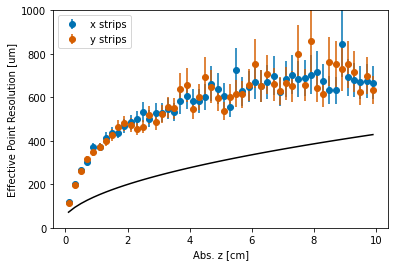

In [9]:

# Get mismeasurement versus abs. z using method 1
abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2,  start = 0.0, stop = DL, step = 0.2, plot=False)


plt.figure()
plt.errorbar(abs_z,np.abs(x_sigmas2),x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
plt.errorbar(abs_z,np.abs(y_sigmas2),y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
plt.plot(abs_z, np.sqrt( ( 200/np.sqrt(12) )**2 +(np.sqrt(abs_z)*DTrans*10000)**2), color=colors["black"] )
plt.ylim([0,1000])
plt.legend()
plt.xlabel("Abs. z [cm]")
plt.ylabel("Effective Point Resolution [um]")
plt.show()

## This does not look good because we need to weight the mismeasurments 

In [10]:
all_c = np.array([])
all_z = np.array([])
all_x_err_1 = np.array([])
all_y_err_1 = np.array([])
all_x_err_2 = np.array([])
all_y_err_2 = np.array([])

for index, row in tracks.iterrows():

    track = row.track

    H, edges = np.histogramdd(track,[np.arange(-5,5,0.02),np.arange(-5,5,0.02),np.arange(0,DL+0.02,0.02)])

    charges = H[H!=0]
    x_vals = (np.nonzero(H)[0]*0.02)-5
    y_vals = (np.nonzero(H)[1]*0.02)-5
    z_vals = (np.nonzero(H)[2]*0.02)+0.01

    z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( x_vals, y_vals, z_vals, charges, charge_weighting = True)

    ang_z = np.arccos(v_PA[2])*57.2958


    if (ang_z>theta_min) and (ang_z<theta_max):
            
        all_z = np.append(all_z,z_vals)
        all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
        all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
        all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
        all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
        all_c = np.append(all_c,charges)


# change to um
all_x_err_2 = all_x_err_2 / 1E-4
all_y_err_2 = all_y_err_2 / 1E-4

sigma x:  75.62265300634762 +/- 0.15981792583886742
sigma y:  75.23897640723021 +/- 0.1530593225738718
sigma x:  98.81917581307181 +/- 0.23210194315727972
sigma y:  -98.9388084155566 +/- 0.22521163586519127
sigma x:  118.26641759411507 +/- 0.3148482191982082
sigma y:  116.58929187107874 +/- 0.30672457498938904
sigma x:  133.71597118424773 +/- 0.4013297806446419
sigma y:  132.58421313389556 +/- 0.393258699870322
sigma x:  149.12495847401024 +/- 0.5111107195368366
sigma y:  146.48130526899487 +/- 0.49580670076170524
sigma x:  -161.57776961839355 +/- 0.6223526265658536
sigma y:  -159.078184682223 +/- 0.5988195867374824
sigma x:  170.9163000552828 +/- 0.727060196970534
sigma y:  -171.22830009497454 +/- 0.7298763178174263
sigma x:  -185.46528519914997 +/- 0.9054157480105754
sigma y:  -181.91394317186965 +/- 0.8576524565810824
sigma x:  -191.81578578145226 +/- 0.9963061871160921
sigma y:  191.64433915435322 +/- 1.0039881390283263
sigma x:  203.2152982582491 +/- 1.1752139499792549
sigma y:  2

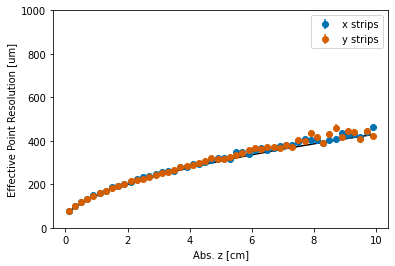

In [11]:

# Get mismeasurement versus abs. z using method 1
abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z_weighted(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2, charge = all_c,  start = 0.0, stop = DL, step = 0.2, plot=False)


plt.figure()
plt.errorbar(abs_z,np.abs(x_sigmas2),x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
plt.errorbar(abs_z,np.abs(y_sigmas2),y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
plt.plot(abs_z, np.sqrt( ( 200/np.sqrt(12) )**2 +(np.sqrt(abs_z)*DTrans*10000)**2), color=colors["black"] )
plt.legend()
plt.ylim([0,1000])
plt.xlabel("Abs. z [cm]")
plt.ylabel("Effective Point Resolution [um]")
plt.show()

# Now consider a perfect strip readout 

Perfect matching (bin in z first the apply strips), no time integration, 50/50 charge sharing, no threshold, 200 um resolution on all axis 

In [12]:

all_z = np.array([])
all_x_err_1 = np.array([])
all_y_err_1 = np.array([])
all_x_err_2 = np.array([])
all_y_err_2 = np.array([])
all_c = np.array([])



for index, row in tracks.iterrows():

    track = row.track

    H, edges = np.histogramdd(track,[np.arange(-5,5,0.02),np.arange(-5,5,0.02),np.arange(0,DL+0.02,0.02)])

    y_hits = np.sum(H,axis=0)
    x_hits = np.sum(H,axis=1)

    x_charges = x_hits[x_hits!=0]
    x_pos = (np.nonzero(x_hits)[0]*0.02)-5
    x_zpos = (np.nonzero(x_hits)[1]*0.02)+0.01


    y_charges = y_hits[y_hits!=0]
    y_pos = (np.nonzero(y_hits)[0]*0.02)-5
    y_zpos = (np.nonzero(y_hits)[1]*0.02)+0.01

    x_vals = []
    y_vals = []
    z_vals = []
    charges = []


    # Here the x and y hits are matched based on which z-bin they are in and charge spread along the vetices
    for z in np.arange(-0.02,DL,0.02):

        x_charges_cut = x_charges[(x_zpos >= z) & (x_zpos < (z+0.02) )]
        x_pos_cut = x_pos[(x_zpos >= z) & (x_zpos < (z+0.02) )]
        x_zpos_cut = x_zpos[(x_zpos >= z) & (x_zpos < (z+0.02) )]

        y_charges_cut = y_charges[(y_zpos >= z) & (y_zpos < (z+0.02) )]
        y_pos_cut = y_pos[(y_zpos >= z) & (y_zpos < (z+0.02) )]
        y_zpos_cut = y_zpos[(y_zpos >= z) & (y_zpos < (z+0.02) )]


        for j in np.arange(len(y_charges_cut)):
            for i in np.arange(len(x_charges_cut)):
                x_vals += [x_pos_cut[i]]
                y_vals += [y_pos_cut[j]]
                z_vals += [z+0.01]
                charges += [ (1.0*x_charges_cut[i]/len(y_charges_cut)) + (1.0*y_charges_cut[j]/len(x_charges_cut)) ]

    z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( np.array(x_vals), np.array(y_vals), np.array(z_vals), np.array(charges), charge_weighting = True)

    ang_z = np.arccos(v_PA[2])*57.2958

    if (ang_z>theta_min) and (ang_z<theta_max):
            
        all_z = np.append(all_z,z_vals)
        all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
        all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
        all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
        all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
        all_c = np.append(all_c,charges)


# change to um
all_x_err_2 = all_x_err_2 / 1E-4
all_y_err_2 = all_y_err_2 / 1E-4







sigma x:  102.35809383516761 +/- 0.1646935232118543
sigma y:  100.86444880353888 +/- 0.15889118926984191
sigma x:  153.69305898267578 +/- 0.4059433051812099
sigma y:  -150.7429934389836 +/- 0.38719595699562065
sigma x:  179.38939408086205 +/- 0.6126482780139529
sigma y:  -178.67583804554621 +/- 0.6045630643648774
sigma x:  -192.73033380090897 +/- 0.7452885986162916
sigma y:  -192.9028994599709 +/- 0.7512921589783013
sigma x:  -209.32217336915497 +/- 0.9388888916307008
sigma y:  203.4017528225009 +/- 0.8842016040758501
sigma x:  -221.31976398531177 +/- 1.1103102121145987
sigma y:  217.2063091665785 +/- 1.0532778763666524
sigma x:  -226.8808260499746 +/- 1.2092141031544423
sigma y:  -230.37778764906577 +/- 1.2656130412425401
sigma x:  -246.13530744172803 +/- 1.5442142130210998
sigma y:  239.57825751612543 +/- 1.4190604499469146
sigma x:  -251.2201564543547 +/- 1.6482225360648763
sigma y:  -251.43209682835956 +/- 1.6727664048795508
sigma x:  -260.7688894166043 +/- 1.8656362964836857
sigma

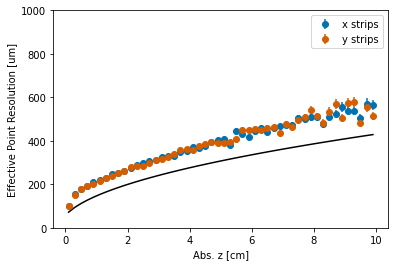

In [13]:

# Get mismeasurement versus abs. z using method 1
abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z_weighted(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2, charge = all_c,  start = 0.0, stop = DL, step = 0.2, plot=False)


plt.figure()
plt.errorbar(abs_z,np.abs(x_sigmas2),x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
plt.errorbar(abs_z,np.abs(y_sigmas2),y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
plt.plot(abs_z, np.sqrt( ( 200/np.sqrt(12) )**2 +(np.sqrt(abs_z)*DTrans*10000)**2), color=colors["black"] )
plt.legend()
plt.ylim([0,1000])
plt.xlabel("Abs. z [cm]")
plt.ylabel("Effective Point Resolution [um]")
plt.show()

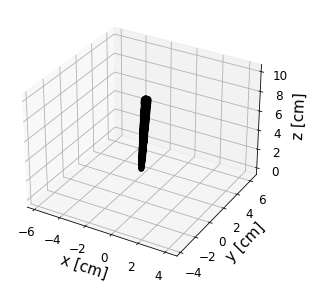

In [14]:
# Plot the track
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(x_vals, y_vals, z_vals, c='k', marker='o', alpha=0.1)

ax.set_xlabel('x [cm]',fontsize=15)
ax.set_ylabel('y [cm]',fontsize=15)
ax.set_zlabel('z [cm]',fontsize=15)
ax.tick_params(labelsize=12)
stripROtools.set_axes_equal(ax)
plt.tight_layout()

This does a little worse for two reasons:
1. The charge distribution is not captured as well for each slice in z, therefore the charge weighting is not as effective
2. Because for each slice in z, every y hit is matched to every x hit, the reconstruction is in the for of rectangles stacked in z (see below)

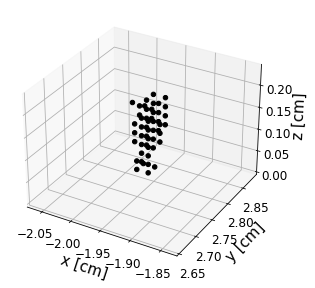

In [15]:
# Plot the track
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(x_vals[0:50], y_vals[0:50], z_vals[0:50], c='k', marker='o', alpha=1)

ax.set_xlabel('x [cm]',fontsize=15)
ax.set_ylabel('y [cm]',fontsize=15)
ax.set_zlabel('z [cm]',fontsize=15)
ax.tick_params(labelsize=12)
stripROtools.set_axes_equal(ax)
plt.tight_layout()

# Now consider a perfect strip readout with a digitization time

Perfect matching (bin in z first the apply strips), no time integration, 50/50 charge sharing, no threshold, 200 um resolution on all axis 
However, after a strip has fired, it will not fire again for [delay] bins in z

In [16]:
# Number of z bins the digitization takes
delay = 30

In [17]:

all_z = np.array([])
all_x_err_1 = np.array([])
all_y_err_1 = np.array([])
all_x_err_2 = np.array([])
all_y_err_2 = np.array([])
all_c = np.array([])



for index, row in tracks.iterrows():

    track = row.track

    H, edges = np.histogramdd(track,[np.arange(-5,5,0.02),np.arange(-5,5,0.02),np.arange(0,DL+0.02,0.02)])

    y_hits = np.sum(H,axis=0)
    x_hits = np.sum(H,axis=1)

    # If there was a previous hit within the delay window, remove the hit
    for i in np.arange(x_hits.shape[1]-1)+1:

        ref = np.maximum(0,i-delay)
        x_hits_history = x_hits[:,ref:i]
        prev_hit_log = ~(np.sum(x_hits_history,axis=1)>0)

        x_hits[:,i] =  x_hits[:,i] * prev_hit_log

    # If there was a previous hit within the delay window, remove the hit
    for i in np.arange(y_hits.shape[1]-1)+1:

        ref = np.maximum(0,i-delay)
        y_hits_history = y_hits[:,ref:i]
        prev_hit_log = ~(np.sum(y_hits_history,axis=1)>0)

        y_hits[:,i] =   y_hits[:,i] * prev_hit_log

    x_charges = x_hits[x_hits!=0]
    x_pos = (np.nonzero(x_hits)[0]*0.02)-5
    x_zpos = (np.nonzero(x_hits)[1]*0.02)+0.01


    y_charges = y_hits[y_hits!=0]
    y_pos = (np.nonzero(y_hits)[0]*0.02)-5
    y_zpos = (np.nonzero(y_hits)[1]*0.02)+0.01

    x_vals = []
    y_vals = []
    z_vals = []
    charges = []


    # Here the x and y hits are matched based on which z-bin they are in and charge spread along the vetices
    for z in np.arange(0,DL,0.02):

        x_charges_cut = x_charges[(x_zpos >= z) & (x_zpos < (z+0.02) )]
        x_pos_cut = x_pos[(x_zpos >= z) & (x_zpos < (z+0.02) )]
        x_zpos_cut = x_zpos[(x_zpos >= z) & (x_zpos < (z+0.02) )]

        y_charges_cut = y_charges[(y_zpos >= z) & (y_zpos < (z+0.02) )]
        y_pos_cut = y_pos[(y_zpos >= z) & (y_zpos < (z+0.02) )]
        y_zpos_cut = y_zpos[(y_zpos >= z) & (y_zpos < (z+0.02) )]


        for j in np.arange(len(y_charges_cut)):
            for i in np.arange(len(x_charges_cut)):
                x_vals += [x_pos_cut[i]]
                y_vals += [y_pos_cut[j]]
                z_vals += [z+0.01]
                charges += [ (1.0*x_charges_cut[i]/len(y_charges_cut)) + (1.0*y_charges_cut[j]/len(x_charges_cut)) ]

    z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( np.array(x_vals), np.array(y_vals), np.array(z_vals), np.array(charges), charge_weighting = True)

    ang_z = np.arccos(v_PA[2])*57.2958

    if (ang_z>theta_min) and (ang_z<theta_max):
            
        all_z = np.append(all_z,z_vals)
        all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
        all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
        all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
        all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
        all_c = np.append(all_c,charges)


# change to um
all_x_err_2 = all_x_err_2 / 1E-4
all_y_err_2 = all_y_err_2 / 1E-4




sigma x:  180.94818881671867 +/- 2.0872409848262143
sigma y:  127.4719804615561 +/- 0.9601918962989575
sigma x:  185.66241992356072 +/- 15.144549125011542
sigma y:  218.59833220792407 +/- 24.8756717137921
sigma x:  234.91069827193127 +/- 34.44167495356489
sigma y:  437.36232153514436 +/- 209.52574040527747
sigma x:  256.1233124361029 +/- 45.644413156641825
sigma y:  5809.405096417692 +/- 507783.3400455261
sigma x:  91.49213937490217 +/- 5.391661612388925
sigma y:  -199.1374477444917 +/- 25.03633009662058
sigma x:  -274.4562934164907 +/- 59.82870815518638
sigma y:  -398.67522467809897 +/- 252.7934973326843
sigma x:  29.019086255509052 +/- 1.1127649039122025
sigma y:  55.11105944849586 +/- 2.1603842097511907
fit failed for z =  1.5
sigma x:  2322.3545877357033 +/- 32809.90690630334
sigma y:  169.50349880620462 +/- 25.838925862598813
fit failed for z =  1.9
sigma x:  163.5261001568352 +/- 11.496584832299215
sigma y:  297.8975533030107 +/- 41.724400290267766
sigma x:  77.65354847694088 +/-

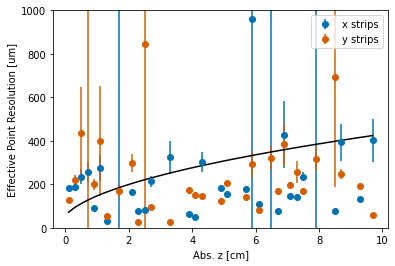

In [18]:
DTrans = 0.0135

# Get mismeasurement versus abs. z using method 1
abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z_weighted(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2, charge = all_c,  start = 0.0, stop = DL, step = 0.2, plot=False)


plt.figure()
plt.errorbar(abs_z,np.abs(x_sigmas2),x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
plt.errorbar(abs_z,np.abs(y_sigmas2),y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
plt.plot(abs_z, np.sqrt( ( 200/np.sqrt(12) )**2 +(np.sqrt(abs_z)*DTrans*10000)**2), color=colors["black"] )
plt.legend()
plt.ylim((0,1000))
plt.xlabel("Abs. z [cm]")
plt.ylabel("Effective Point Resolution [um]")
plt.show()

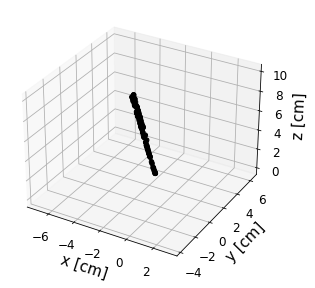

In [19]:
# Plot the track
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(x_vals[0], y_vals, z_vals, c='k', marker='o', alpha=1)

ax.set_xlabel('x [cm]',fontsize=15)
ax.set_ylabel('y [cm]',fontsize=15)
ax.set_zlabel('z [cm]',fontsize=15)
ax.tick_params(labelsize=12)
stripROtools.set_axes_equal(ax)
plt.tight_layout()

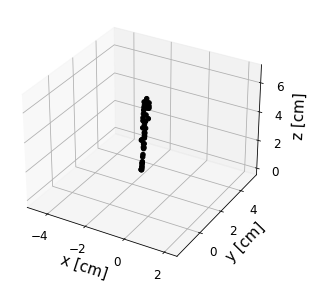

In [20]:
# Plot the track
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(x_vals[0:50], y_vals[0:50], z_vals[0:50], c='k', marker='o', alpha=1)

ax.set_xlabel('x [cm]',fontsize=15)
ax.set_ylabel('y [cm]',fontsize=15)
ax.set_zlabel('z [cm]',fontsize=15)
ax.tick_params(labelsize=12)
stripROtools.set_axes_equal(ax)
plt.tight_layout()

# Now consider a perfect strip readout with charge integration

Each strip integrats charge individually, abs z is the charge avergaed position above the strip.

In [21]:
DL = 10.0 

all_z = np.array([])
all_x_err_1 = np.array([])
all_y_err_1 = np.array([])
all_x_err_2 = np.array([])
all_y_err_2 = np.array([])
all_c = np.array([])



for index, row in tracks.iterrows():

    track = row.track
    
    H, edges = np.histogramdd(track,[np.arange(-5,5,0.02),np.arange(-5,5,0.02),np.arange(0,DL+0.02,0.02)])

    y_hits = np.sum(H,axis=0)
    x_hits = np.sum(H,axis=1)

    x_zpos = []
    x_charges = []
    x_pos = []

    for i in np.arange(x_hits.shape[0]):

        if np.max(x_hits[i,:]) > 0:

            x_zpos += [np.dot( x_hits[i,:], np.arange(len(x_hits[i,:]) ) * 0.02 + 0.01  ) / np.sum(x_hits[i,:])]
            x_pos += [i*0.02-5]
            x_charges +=  [np.sum(x_hits[i,:])]


    y_zpos = []
    y_charges = []
    y_pos = []


    for i in np.arange(y_hits.shape[0]):

        if np.max(y_hits[i,:]) > 0:

            y_zpos += [np.dot( y_hits[i,:], np.arange(len(y_hits[i,:]) ) * 0.02 + 0.01  ) / np.sum(y_hits[i,:])]
            y_pos += [i*0.02-5]
            y_charges +=  [np.sum(y_hits[i,:])]

    y_zpos = np.array(y_zpos)
    y_charges = np.array(y_charges)
    y_pos = np.array(y_pos)
    x_zpos = np.array(x_zpos)
    x_charges = np.array(x_charges)
    x_pos = np.array(x_pos)

    # Match x and y hits if they are within 3 sigma, where sigma is 0.016 cm 

    Tarray = np.abs(np.subtract.outer(x_zpos,y_zpos) / 0.016) < 3

    # This counts the number of simultaniously triggering y hits for each x hit
    TCol = np.sum(Tarray,axis=1)*1.0
    # This counts the number of simultaniously triggering x hits for each y hit
    TRow = np.sum(Tarray,axis=0)*1.0

    unmatched_ADCs = np.append(x_charges[ TCol == 0 ] , y_charges [ TRow == 0 ])
    unmatched_times = np.append( x_zpos[ TCol == 0 ] ,  y_zpos[ TRow == 0 ] )

    # Rebuild arrays, ommiting unmatched hits
    # Convert ADC to electron count units
    x_times = x_zpos[ TCol > 0 ]
    ADC_x = x_charges[ TCol > 0 ]
    strips_x = x_pos[ TCol > 0 ]
    y_times = y_zpos[ TRow > 0 ]
    ADC_y = y_charges[ TRow > 0 ] 
    strips_y = y_pos[ TRow > 0 ]
    Tarray = np.abs((np.subtract.outer(x_times,y_times)) / 0.016) < 3
    TCol = np.sum(Tarray,axis=1)*1.0
    TRow = np.sum(Tarray,axis=0)*1.0

    # This divides the ADC of the x hit by the number of simultaniously triggering y hits
    ADCx_V = np.divide(ADC_x,TCol)

    # This is a matrix of the x ADC contribution to all xy-hits
    elecx_M = np.multiply(ADCx_V[..., None],Tarray)

    # This divides the ADC of the y hit by the number of simultaniously triggering x hits
    ADCy_V = np.divide(ADC_y,TRow)

    # This is a matrix of the y ADC contribution to all xy-hits
    elecy_M = np.multiply(ADCy_V,Tarray)

    # This is the total ADC assigned to each xy-hit
    elec_M = elecx_M+elecy_M

    # This holds the x strip position for each xy-hit
    Stripx_M = np.multiply(strips_x[..., None],Tarray)

    # This holds the y strip position for each xy-hit
    Stripy_M = np.multiply(strips_y,Tarray)

    # This holds the x time measurment for each xy-hit
    Timex_M = np.multiply(x_times[..., None],Tarray)

    # This holds the y time measurment for each xy-hit
    Timey_M = np.multiply(y_times,Tarray)

    # This holds the average time measurment for each xy-hit
    Time_M = (Timex_M + Timey_M) / 2.0

    # absolute time offsets between matched vertices and unmatched hits
    abs_t_off = np.abs( Time_M-np.tensordot(unmatched_times, Tarray, axes=0) )
    # Really we want to weight by the inverse time difference 
    abs_t_off = np.reciprocal(abs_t_off,where= abs_t_off!=0)

    # Corresponding umatched ADC and time offset normalization factor
    ADC_norm = unmatched_ADCs/abs_t_off.sum(axis=1).sum(axis=1)

    # Multiply togather and sum to get total unmatched ADC contribution for each vertex
    unmatched_contrib = (abs_t_off*np.tensordot(ADC_norm, Tarray, axes=0)).sum(axis=0)

    # Add to ADC matrix
    elec_M += unmatched_contrib

    # Convert to physical quatities
    x_vals = Stripx_M[Tarray]           # Multiply by pitch for physical distance
    y_vals = Stripy_M[Tarray]           # Multiply by pitch for physical distance
    charges = elec_M[Tarray]            # Weight is number of electrons
    z_vals  = Time_M[Tarray]            # multiply by drift speed for z
    z_vals = z_vals - np.min(z_vals)+0.01                    # Shift z_vals so that minimum is at z=0

    z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( np.array(x_vals), np.array(y_vals), np.array(z_vals), np.array(charges), charge_weighting = True)

    ang_z = np.arccos(v_PA[2])*57.2958

    if (ang_z>theta_min) and (ang_z<theta_max):
            
        all_z = np.append(all_z,z_vals)
        all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
        all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
        all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
        all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
        all_c = np.append(all_c,charges)


# change to um
all_x_err_2 = all_x_err_2 / 1E-4
all_y_err_2 = all_y_err_2 / 1E-4


/Users/majdghrear/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in reciprocal


sigma x:  60.87972696148505 +/- 0.06626378190440119
sigma y:  75.92677652110221 +/- 0.10077909439527301
sigma x:  61.26844699451583 +/- 0.12618277822198834
sigma y:  61.88070484501878 +/- 0.10549861865905381
sigma x:  61.63832394530707 +/- 0.10392264990910498
sigma y:  58.64957524365549 +/- 0.10853942719987966
sigma x:  53.99433326094892 +/- 0.09937729850552912
sigma y:  54.788082831111275 +/- 0.09287147246221089
sigma x:  52.20345644703662 +/- 0.07404922935732373
sigma y:  67.50063657502015 +/- 0.12637721377921912
sigma x:  58.807272180714996 +/- 0.12176109272802
sigma y:  56.32655328220566 +/- 0.10965291278193456
sigma x:  51.18025566452264 +/- 0.07353056057632329
sigma y:  53.62591669433904 +/- 0.11948527816416186
sigma x:  53.057640639636254 +/- 0.08088629743168907
sigma y:  55.642164782152385 +/- 0.09925610691269908
sigma x:  -52.96432624967815 +/- 0.08264332336296412
sigma y:  49.53064324851834 +/- 0.08751019679934152
sigma x:  45.51766079070555 +/- 0.07541864129033381
sigma y:  

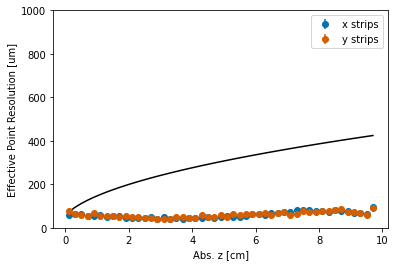

In [22]:

# Get mismeasurement versus abs. z using method 1
abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z_weighted(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2, charge = all_c,  start = 0.0, stop = DL, step = 0.2, plot=False)


plt.figure()
plt.errorbar(abs_z,np.abs(x_sigmas2),x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
plt.errorbar(abs_z,np.abs(y_sigmas2),y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
plt.plot(abs_z, np.sqrt( ( 200/np.sqrt(12) )**2 +(np.sqrt(abs_z)*DTrans*10000)**2), color=colors["black"] )
plt.legend()
plt.ylim((0,1000))
plt.xlabel("Abs. z [cm]")
plt.ylabel("Effective Point Resolution [um]")
plt.show()

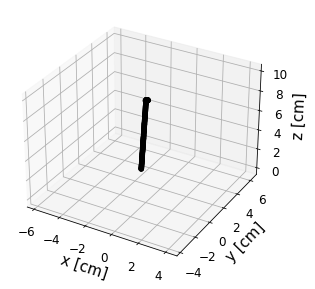

In [23]:
# Plot the track
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(x_vals, y_vals, z_vals, c='k', marker='o', alpha=1)

ax.set_xlabel('x [cm]',fontsize=15)
ax.set_ylabel('y [cm]',fontsize=15)
ax.set_zlabel('z [cm]',fontsize=15)
ax.tick_params(labelsize=12)
stripROtools.set_axes_equal(ax)
plt.tight_layout()

# Now consider a perfect strip readout with charge integration for [bins_integrated] bins

Each strip integrats charge individually, abs z is the charge avergaed position above the strip.

In [84]:
bins_integrated = 20

In [85]:
DL = 10.0 

all_z = np.array([])
all_x_err_1 = np.array([])
all_y_err_1 = np.array([])
all_x_err_2 = np.array([])
all_y_err_2 = np.array([])
all_c = np.array([])



for index, row in tracks.iterrows():

    track = row.track
    
    H, edges = np.histogramdd(track,[np.arange(-5,5,0.02),np.arange(-5,5,0.02),np.arange(0,DL+0.02,0.02)])

    y_hits = np.sum(H,axis=0)
    x_hits = np.sum(H,axis=1)

    x_zpos = []
    x_charges = []
    x_pos = []

    for i in np.arange(x_hits.shape[0]):

        if np.max(x_hits[i,:]) > 0:


            # index of 1st non-zero entry
            i1 = (x_hits[i,:]!=0).argmax(axis=0)
            i2 = i1 + bins_integrated
            
            x_zpos += [np.dot( x_hits[i,i1:i2], (np.arange(len(x_hits[i,:]) ) * 0.02 + 0.01)[i1:i2]  ) / np.sum(x_hits[i,i1:i2])]
            x_pos += [i*0.02-5]
            x_charges +=  [np.sum(x_hits[i,i1:i2])]


    y_zpos = []
    y_charges = []
    y_pos = []


    for i in np.arange(y_hits.shape[0]):

        if np.max(y_hits[i,:]) > 0:

            # index of 1st non-zero entry
            i1 = (y_hits[i,:]!=0).argmax(axis=0)
            i2 = i1 + bins_integrated
            
            y_zpos += [np.dot( y_hits[i,i1:i2], (np.arange(len(y_hits[i,:]) ) * 0.02 + 0.01)[i1:i2]  ) / np.sum(y_hits[i,i1:i2])]
            y_pos += [i*0.02-5]
            y_charges +=  [np.sum(y_hits[i,i1:i2])]

    y_zpos = np.array(y_zpos)
    y_charges = np.array(y_charges)
    y_pos = np.array(y_pos)
    x_zpos = np.array(x_zpos)
    x_charges = np.array(x_charges)
    x_pos = np.array(x_pos)

    # Match x and y hits if they are within 3 sigma, where sigma is 0.016 cm 

    Tarray = np.abs(np.subtract.outer(x_zpos,y_zpos) / 0.016) < 3

    # This counts the number of simultaniously triggering y hits for each x hit
    TCol = np.sum(Tarray,axis=1)*1.0
    # This counts the number of simultaniously triggering x hits for each y hit
    TRow = np.sum(Tarray,axis=0)*1.0

    unmatched_ADCs = np.append(x_charges[ TCol == 0 ] , y_charges [ TRow == 0 ])
    unmatched_times = np.append( x_zpos[ TCol == 0 ] ,  y_zpos[ TRow == 0 ] )

    # Rebuild arrays, ommiting unmatched hits
    # Convert ADC to electron count units
    x_times = x_zpos[ TCol > 0 ]
    ADC_x = x_charges[ TCol > 0 ]
    strips_x = x_pos[ TCol > 0 ]
    y_times = y_zpos[ TRow > 0 ]
    ADC_y = y_charges[ TRow > 0 ] 
    strips_y = y_pos[ TRow > 0 ]
    Tarray = np.abs((np.subtract.outer(x_times,y_times)) / 0.016) < 3
    TCol = np.sum(Tarray,axis=1)*1.0
    TRow = np.sum(Tarray,axis=0)*1.0

    # This divides the ADC of the x hit by the number of simultaniously triggering y hits
    ADCx_V = np.divide(ADC_x,TCol)

    # This is a matrix of the x ADC contribution to all xy-hits
    elecx_M = np.multiply(ADCx_V[..., None],Tarray)

    # This divides the ADC of the y hit by the number of simultaniously triggering x hits
    ADCy_V = np.divide(ADC_y,TRow)

    # This is a matrix of the y ADC contribution to all xy-hits
    elecy_M = np.multiply(ADCy_V,Tarray)

    # This is the total ADC assigned to each xy-hit
    elec_M = elecx_M+elecy_M

    # This holds the x strip position for each xy-hit
    Stripx_M = np.multiply(strips_x[..., None],Tarray)

    # This holds the y strip position for each xy-hit
    Stripy_M = np.multiply(strips_y,Tarray)

    # This holds the x time measurment for each xy-hit
    Timex_M = np.multiply(x_times[..., None],Tarray)

    # This holds the y time measurment for each xy-hit
    Timey_M = np.multiply(y_times,Tarray)

    # This holds the average time measurment for each xy-hit
    Time_M = (Timex_M + Timey_M) / 2.0

    # absolute time offsets between matched vertices and unmatched hits
    abs_t_off = np.abs( Time_M-np.tensordot(unmatched_times, Tarray, axes=0) )
    # Really we want to weight by the inverse time difference 
    abs_t_off = np.reciprocal(abs_t_off,where= abs_t_off!=0)

    # Corresponding umatched ADC and time offset normalization factor
    ADC_norm = unmatched_ADCs/abs_t_off.sum(axis=1).sum(axis=1)

    # Multiply togather and sum to get total unmatched ADC contribution for each vertex
    unmatched_contrib = (abs_t_off*np.tensordot(ADC_norm, Tarray, axes=0)).sum(axis=0)

    # Add to ADC matrix
    elec_M += unmatched_contrib

    # Convert to physical quatities
    x_vals = Stripx_M[Tarray]           # Multiply by pitch for physical distance
    y_vals = Stripy_M[Tarray]           # Multiply by pitch for physical distance
    charges = elec_M[Tarray]            # Weight is number of electrons
    z_vals  = Time_M[Tarray]            # multiply by drift speed for z
    z_vals = z_vals - np.min(z_vals)+0.01                    # Shift z_vals so that minimum is at z=0

    z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( np.array(x_vals), np.array(y_vals), np.array(z_vals), np.array(charges), charge_weighting = True)

    ang_z = np.arccos(v_PA[2])*57.2958

    if (ang_z>theta_min) and (ang_z<theta_max):
            
        all_z = np.append(all_z,z_vals)
        all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
        all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
        all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
        all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
        all_c = np.append(all_c,charges)


# change to um
all_x_err_2 = all_x_err_2 / 1E-4
all_y_err_2 = all_y_err_2 / 1E-4


/Users/majdghrear/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in reciprocal


sigma x:  83.65345645914269 +/- 0.12007000196112798
sigma y:  90.63372579367669 +/- 0.1274136101241846
sigma x:  65.22859184259976 +/- 0.103625495579815
sigma y:  71.52961189980866 +/- 0.13112230492801416
sigma x:  63.0191280774464 +/- 0.10522984839632263
sigma y:  74.02133026847257 +/- 0.17734864899333644
sigma x:  57.61855363553843 +/- 0.10686432481802395
sigma y:  59.13480816582442 +/- 0.11078492533401627
sigma x:  57.615034056782676 +/- 0.09912546844802263
sigma y:  56.50194587472817 +/- 0.10100642450791027
sigma x:  52.0365868401612 +/- 0.09393623747869834
sigma y:  57.673743062666674 +/- 0.12350331239838241
sigma x:  51.39340577338465 +/- 0.08791950644028991
sigma y:  54.258759672440206 +/- 0.10085152097409271
sigma x:  53.92576525695381 +/- 0.09200376905507157
sigma y:  48.31660086334373 +/- 0.09724799841139366
sigma x:  50.79241604126177 +/- 0.08812502777116812
sigma y:  54.91328589529939 +/- 0.10676189539600323
sigma x:  52.54473704596248 +/- 0.09305838744993487
sigma y:  57.3

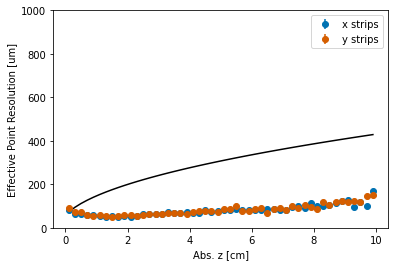

In [86]:

# Get mismeasurement versus abs. z using method 1
abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z_weighted(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2, charge = all_c,  start = 0.0, stop = DL, step = 0.2, plot=False)


plt.figure()
plt.errorbar(abs_z,np.abs(x_sigmas2),x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
plt.errorbar(abs_z,np.abs(y_sigmas2),y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
plt.plot(abs_z, np.sqrt( ( 200/np.sqrt(12) )**2 +(np.sqrt(abs_z)*DTrans*10000)**2), color=colors["black"] )
plt.legend()
plt.ylim((0,1000))
plt.xlabel("Abs. z [cm]")
plt.ylabel("Effective Point Resolution [um]")
plt.show()

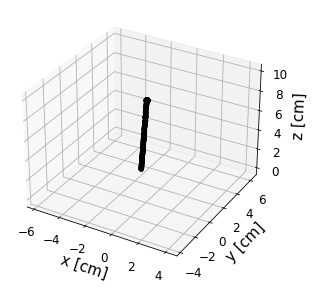

In [87]:
# Plot the track
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(x_vals, y_vals, z_vals, c='k', marker='o', alpha=1)

ax.set_xlabel('x [cm]',fontsize=15)
ax.set_ylabel('y [cm]',fontsize=15)
ax.set_zlabel('z [cm]',fontsize=15)
ax.tick_params(labelsize=12)
stripROtools.set_axes_equal(ax)
plt.tight_layout()